In [1]:
import yaml
import os
import utm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.lines import Line2D
import cartopy.crs as ccrs
import cartopy.io.img_tiles as tilers
import json
import sys

if 'REPO_PATH' not in locals():
    os.chdir('../')
    REPO_PATH = os.getcwd()

from dubinstracking.pathplanning import OrbitFactory, MorphingOrbit
mpl.rcParams.update({'font.size': 8})

In [2]:
with open('data/experimental/jackal_gps_trace_1.yml') as f:
    data = f.read().split('---\n')
as_dict = [yaml.safe_load(d) for d in data]

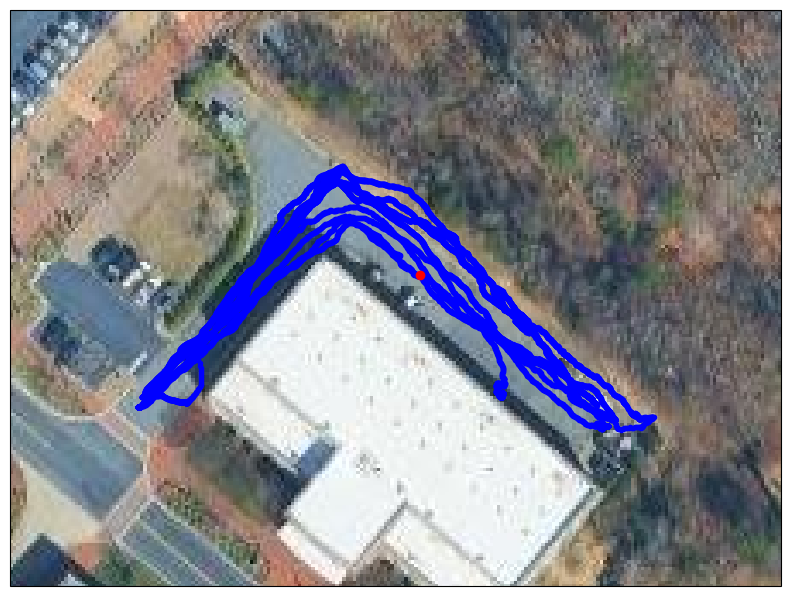

In [4]:
latlon = np.array([
    (
        d['header']['stamp']['secs'] + d['header']['stamp']['nsecs'] * 1e-9,
        d['latitude'],
        d['longitude']
    )
    for d in as_dict if d is not None
])
latlon[:, 0] = latlon[:, 0] - latlon[0, 0]
origin = [35.312865337828214,
        -80.74022444600895]
fig = plt.figure(figsize=(12,6))
tiler = tilers.GoogleTiles(style='satellite')
cm = plt.get_cmap('cool')
ds = .0002

ax = fig.add_subplot(projection=tiler.crs)

ax.stock_img()
targetLine = ax.scatter(latlon[:, 2], latlon[:, 1], transform=ccrs.PlateCarree(), color='b', marker='.')
ax.set_extent([min(latlon[:, 2]) - ds , max(latlon[:, 2]) + ds, min(latlon[:, 1]) - ds, max(latlon[:, 1]) + ds], crs=ccrs.PlateCarree())
ax.add_image(tiler, 18)
ax.scatter([origin[1]], [origin[0]], color='r', transform=ccrs.PlateCarree())

fig.tight_layout()
fig.savefig('notebooks/figures/poi_campus.pdf')

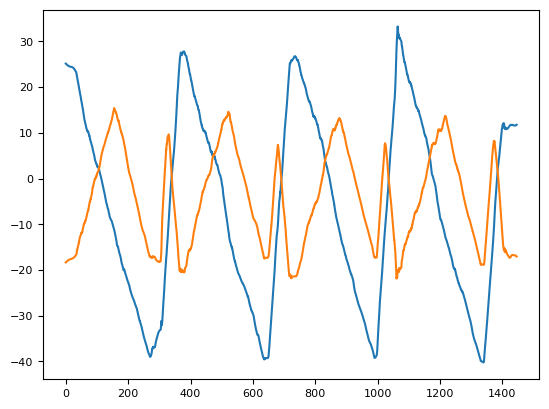

In [5]:
x, y, zone, letter = utm.from_latlon(latlon[:, 1], latlon[:, 2])
xorigin, yorigin, _, _ = utm.from_latlon(origin[0], origin[1])
x = x - xorigin
y = y - yorigin
plt.plot(latlon[:, 0], x)
plt.plot(latlon[:, 0], y)

jackal speed = 0.41595m/s
start index 7450 end index 9651


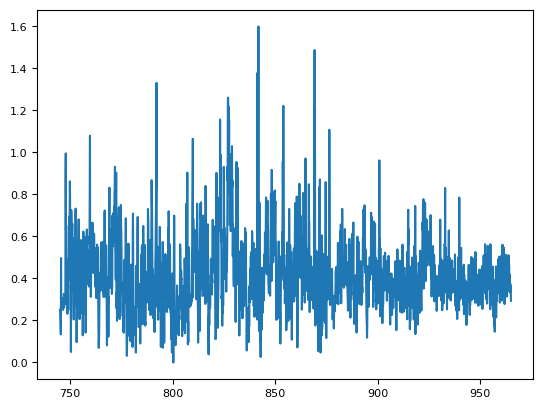

In [6]:
xdot = (x[1:] - x[:-1]) / (latlon[1:, 0] - latlon[:-1, 0])
ydot = (y[1:] - y[:-1]) / (latlon[1:, 0] - latlon[:-1, 0])
speed = np.sqrt(xdot ** 2 + ydot ** 2)
window = np.ones([1])
window = window / window.shape[0]

t_s = 745
t_f = 965
speed_avg = np.convolve(speed, window, 'same')
n = (latlon[:, 0] < t_f).sum()
p = (latlon[:, 0] < t_s).sum()
plt.plot(latlon[p:n, 0], speed_avg[p:n])
time = latlon[p:n, 0]
avg_value_speed = np.sum((time[1:] - time[:-1]) * speed_avg[p:n-1] / (time[-1] - time[0]))
print(f'jackal speed = {avg_value_speed:.5f}m/s')
print(f'start index {p} end index {n}')

2399
[[ -0.273829     0.26052364]
 [ -0.23399451  -0.29708705]
 [ 20.8301758  -15.99273371]]
2450
[[ -0.26866522   0.23450939]
 [ -0.2632276   -0.29171449]
 [ 25.35388769 -15.85704549]]
2201
[[ -0.28437428   0.2552351 ]
 [ -0.27533508  -0.28816481]
 [ 27.35457345 -19.28819095]]
2500
[[ -0.2976889    0.22453877]
 [ -0.24565877  -0.29912023]
 [ 30.30686336 -17.66314064]]


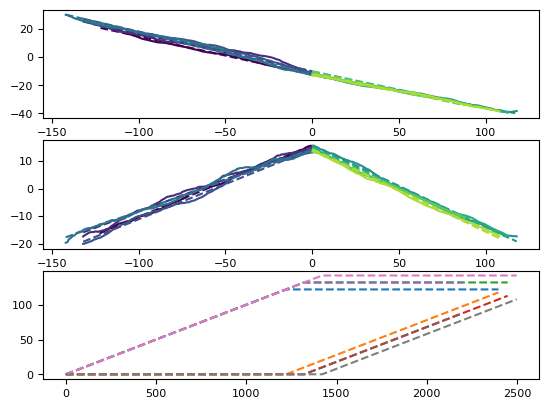

In [7]:

def fit(local, time, sections, axes, j=0):
    cm = plt.get_cmap('viridis')
    t_0 = time[sections[0][1]]
    for i, section in enumerate(sections):
        axes[0].plot(time[section[0]: section[1]] - t_0, local[section[0]: section[1], 0], color=cm(j + i * .5))
        axes[1].plot(time[section[0]: section[1]] - t_0, local[section[0]: section[1], 1], color=cm(j + i * .5))
    x_v = local[:sections[-1][1], 0]
    A = np.zeros([x_v.shape[0], 3])
    A[sections[0][0]:sections[0][1], 0] = time[sections[0][0]:sections[0][1]] - time[sections[0][0]]
    A[sections[0][1]:, 0] = time[sections[0][1]] - time[sections[0][0]]
    A[sections[1][0]:sections[1][1], 1] = time[sections[1][0]:sections[1][1]] - time[sections[1][0]]
    A[sections[1][1]:, 1] = time[sections[1][1]] - time[sections[1][0]]
    A[:, 2] = 1

    c = np.linalg.inv(A.T @ A) @ A.T @ x_v
    d = np.linalg.inv(A.T @ A) @ A.T @ local[:sections[-1][1], 1]

    for i, section in enumerate(sections):
        axes[0].plot(time[section[0]:section[1]] - t_0, A[section[0]:section[1]] @ c, color=cm(j + i * .5), ls='--')
        axes[1].plot(time[section[0]:section[1]] - t_0, A[section[0]:section[1]] @ d, color=cm(j + i * .5), ls='--')
    A[sections[0][1]-2:sections[0][1] + 2]
    beta = np.array([c, d]).T
    axes[2].plot(A[:, 0], '--')
    axes[2].plot(A[:, 1], '--')
    return beta

starts = [351, 3900, 7450, 10751]
ends = [2750, 6350, 9651, 13251]

local = np.column_stack([x[p:n], y[p:n]])
sections = [
    [
        (0, 1220),
        (1220, 2398),
    ],
    [
        (0, 1320),
        (1320, 2449)
    ],
    [
        (0, 1320),
        (1320, 2200)
    ],
    [
        (0, 1420),
        (1420, 2499)
    ],
]
fig = plt.figure()
axes = fig.subplots(3)
for i in range(len(sections)):
    p = starts[i]
    n = ends[i]
    time = latlon[p:n, 0]
    local = np.column_stack([x[p:n], y[p:n]])
    print(n - p)
    beta = fit(local, time, sections[i], axes, j=.5*i / (len(sections)))
    print(beta)

[121.99799109 132.00453496 131.9904511  141.99393177]
[239.81066108 244.88448882 219.99001503 249.88694477]
131.99672722816467 238.64302742481232


(array([[-132.,    0.,    1.],
        [   0.,    0.,    1.],
        [   0.,  107.,    1.]]),
 array([ 26.17831872, -11.33562022, -38.18445791]),
 array([-17.06952157,  14.79610725, -16.49890478]),
 array([-132.,    0.,  107.]))

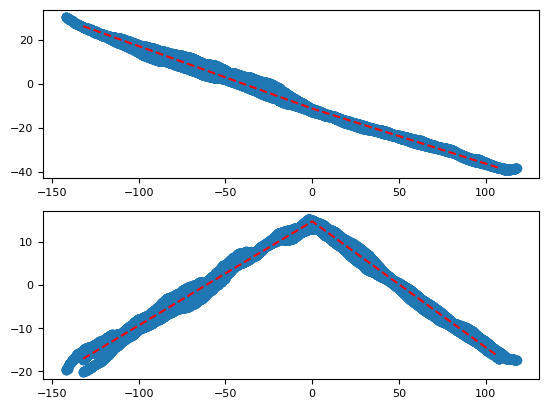

In [8]:
t_m = latlon[[sections[i][0][1] + starts[i] for i in range(len(sections))], 0] - latlon[starts, 0]
t_e = latlon[[sections[i][1][1] + starts[i] for i in range(len(sections))], 0] - latlon[starts, 0]
print(t_m)
print(t_e)
print(t_m.mean(), t_e.mean())
n = sum([sections[i][1][1] - sections[i][0][0] for i in range(len(sections))])
A = np.zeros([n, 3])
A[:, 2] = 1
offset = 0
for i in range(len(sections)):
    section = sections[i]
    time = latlon[starts[i]:ends[i], 0]
    A[offset + section[0][0]:offset + section[0][1], 0] = time[section[0][0]:section[0][1]] - time[section[0][0]] - t_m[i]
    A[offset + section[1][0]:offset + section[1][1], 0] = time[section[0][1]] - time[section[0][0]] - t_m[i]
    A[offset + section[1][0]:offset + section[1][1], 1] = time[section[1][0]:section[1][1]] - time[section[1][0]]
    offset += section[1][1] - section[0][0]

indices = []
for i in range(len(sections)):
    indices += list(range(starts[i], starts[i] + sections[i][-1][1]))
beta_x = np.linalg.inv(A.T @ A) @ A.T @ x[indices]
beta_y = np.linalg.inv(A.T @ A) @ A.T @ y[indices]

beta = np.column_stack([beta_x, beta_y])

AA = np.array([[-132.0, 0, 1],
               [0, 0, 1],
               [0, 239 - 132, 1]])

fig = plt.figure()
axes = fig.subplots(2)
axes[0].plot(AA[:, :2].sum(axis=1), AA @ beta_x, 'r--')
axes[1].plot(AA[:, :2].sum(axis=1), AA @ beta_y, 'r--')

axes[0].scatter(A[:, :2].sum(axis=1), x[indices])
axes[1].scatter(A[:, :2].sum(axis=1), y[indices])


x_data = x[indices]
y_data = y[indices]
latlon_data = np.array(utm.to_latlon(x_data + xorigin, y_data + yorigin, zone, letter)).T
time_data = latlon[indices, 0]

estimated = np.array([AA @ beta_x, AA @ beta_y]).T

AA, AA @ beta_x, AA @ beta_y, AA[:, :2].sum(axis=1)

In [9]:
np.sum(np.linalg.norm(beta[:2, :], axis=1) * [132, 107]) / (239), beta

(np.float64(0.3784728558072508),
 array([[ -0.28419651,   0.24140628],
        [ -0.25092372,  -0.29247675],
        [-11.33562022,  14.79610725]]))

In [18]:
missionPlan = 'data/environments/battcave/circles.json'
missionOrigin = 'data/environments/battcave/gps_origin.json'
if missionPlan is not None:
    with open(missionPlan) as f:
        plan = json.load(f)
    orbits = [OrbitFactory.fromJson(p) for p in plan]

missionHome = [xorigin,yorigin]

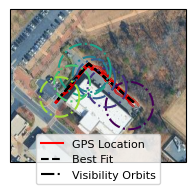

In [19]:
fig = plt.figure(figsize=(2, 2))
ax = fig.add_subplot(projection=tiler.crs)
ds = .0004
ax.stock_img()
targetLine = ax.scatter(latlon_data[:, 1], latlon_data[:, 0], s=.001, transform=ccrs.PlateCarree(), color='r', marker='.')
ax.set_extent([min(latlon[:, 2]) - ds , max(latlon[:, 2]) + ds, min(latlon[:, 1]) - ds, max(latlon[:, 1]) + ds], crs=ccrs.PlateCarree())
ax.add_image(tiler, 18)
cm = plt.get_cmap('viridis')

for i, section in enumerate(sections):
    
    lat, lon = utm.to_latlon(estimated[:, 0] + xorigin, estimated[:, 1] + yorigin, zone, letter)
    ax.plot(lon, lat, transform=ccrs.PlateCarree(), color='k', ls='--')

for i, orbit in enumerate(orbits):
    theta = np.linspace(0, 2 * np.pi)
    r = np.array([orbit.radius(t) for t in theta])
    xy = (r * np.array([np.cos(theta), np.sin(theta)])).T + missionHome + orbit.g_0
    lat, lon = utm.to_latlon(xy[:, 0], xy[:, 1], zone, letter)
    oribts_handle, = ax.plot(lon, lat, color=cm(i / len(orbits)), ls='-.', transform=ccrs.PlateCarree())

fig.legend(
    [
        Line2D([0], [0], ls='-', color='r'), 
        Line2D([0], [0], ls='--', color='k'), 
        Line2D([0], [0], ls='-.', color='k')
    ],
    [
        'GPS Location',
        r'Best Fit',
        r'Visibility Orbits'
    ], 
    loc='lower center'
)
fig.tight_layout()
fig.savefig('notebooks/figures/poi_campus.pdf', bbox_inches='tight')

In [20]:
with open(f'data/experimental/jackal_path.csv', 'w') as f:
    for i, _ in enumerate(estimated):
            f.write(','.join(map(str, estimated[i, :])) + ',0.5')
            f.write('\n')
    f.write('\n')